In [1]:
import numpy as np
from boxvectors import directions as directions
import Initial_Parameters as ip
from md import System
from md import md
from distribution import maxwellboltzmann
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfc
from scipy.constants import epsilon_0
%matplotlib inline

In [2]:
Symbols = ip.Symbols
Coefficients = ip.Coefficients
Charges = ip.Charges
N = ip.N*np.sum(Coefficients)
L = ip.L
T = ip.T
dt = ip.dt
p_rea = ip.p_rea
p = ip.p
std = ip.std
k_cut = ip.k_cut
k_max = ip.k_max_long_range
n_boxes_LJ = ip.n_boxes_LJ
n_boxes_coulomb = ip.n_boxes_short_range
Sys= System(Symbols, Coefficients, Charges, N/2)
Labels = Sys.get_Labels()
Sigma, Epsilon = Sys.get_LJ_parameter()

m = Labels[:,0]

In [3]:
switch_parameter = np.array([1,-1,0,0])
r_switch = 1.5

In [4]:
def get_random_starting_Positions(N,L):
    Positions = np.zeros((N,3))
    Positions[:,0] = np.linspace(0.1/N,L[0],N, endpoint = False)
    Positions[:,1] = np.linspace(0.1/N,L[1],N, endpoint = False)
    Positions[:,2] = np.linspace(0.1/N,L[2],N, endpoint = False)
    np.random.shuffle(Positions[:,0])
    np.random.shuffle(Positions[:,1])
    np.random.shuffle(Positions[:,2])
    return Positions
Positions = get_random_starting_Positions(N,L)
Velocities = maxwellboltzmann().sample_distribution(N,m,T)
Forces = np.zeros((N,3))
R = np.linalg.norm(Positions,axis=1)

In [5]:
MD = md(
    Positions, 
    R, 
    Labels, 
    Velocities,
    Forces, 
    L, 
    T, 
    std, 
    Sigma, 
    Epsilon, 
    switch_parameter,
    r_switch, 
    n_boxes_coulomb, 
    k_max, 
    dt, 
    p_rea,
    k_cut)


In [6]:
MD.forces = MD.get_forces()

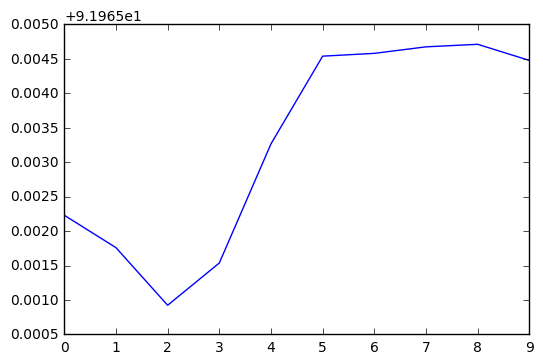

In [12]:
Temperature = np.zeros(10)
for i in np.arange(10):
    Positions_New, Velocities_New, Forces_New = MD.propagte_system()
    MD.positions = Positions_New
    MD.velocities = Velocities_New
    MD.forces = Forces_New
    Temperature[i] = MD.get_Temperature()
plt.plot(Temperature)

In [28]:
assert np.all((np.identity(3)).transpose() == np.identity(3))

## How to Save trajectory frame in xyz format (no header)

In [115]:
frame = np.zeros((N), dtype=[('var1', 'S6'), ('var2', 'float64'), ('var3', 'float64'), ('var4', 'float64')])
frame['var1'] = Symbols[Labels[:,2].astype(int)]
frame['var2'] = MD.positions[:,0]
frame['var3'] = MD.positions[:,1]
frame['var4'] = MD.positions[:,2]

myfile = open("positions.txt",'a')
np.savetxt(myfile,frame, fmt = ('%.10s %.32e %.32e %.32e'))
myfile.close()